In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycountry
import os
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline

## Exercise 1

In order to generate a wordcloud, we need to do some preparation work. First of all, we create dataframe form file Emails.csv. The necessary data is contained in the field "ExtractedBodyText". We delete all rows in which there is no value in this field. Then we join all the texts of messages into one Pythin string.

In [9]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', index_col=0)
emails_raw_cleaned = emails.dropna(subset=["ExtractedBodyText"])
email_text = " ".join(emails_raw_cleaned.ExtractedBodyText)

Generation of wordcloud is trivial. However, it is necessary to take into consideration the fact that wordcloud library, by default, delete stopwords. As far as we want to degerate the first wordcloud on raw corpus, without any pre-processing, we need to assign [ ] (empty list) as "stopword" parameter.

In [79]:
wordcloud = WordCloud(scale=4, background_color='white', stopwords=[]).generate(email_text)

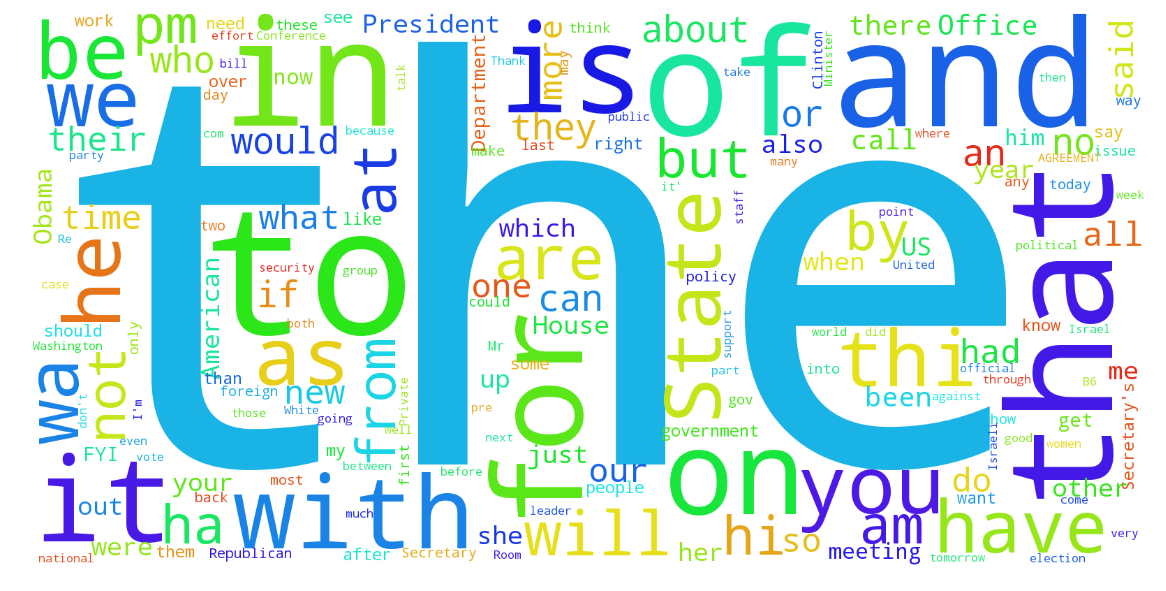

In [80]:
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Second wordcloud must be generated after a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming).

In [81]:
#tokenization
email_text_tokens = word_tokenize(email_text.lower())

In [82]:
#removing stopwords: standart stopwords+punctuation+some others.
stop = stopwords.words('english') + list(string.punctuation) + \
    ["''", '``', '--', '—', '•',"'s", "'m", "'ve", "n't", "'re", "'ll", "..."]
tokens_without_stopwords = [word for word in email_text_tokens if word not in stop]

In [83]:
#stemming
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(word) for word in tokens_without_stopwords]

To denerate new wordcloud from tokens after pre-processing pipeline, we need to know how frequent each unique token appears. FreqDist allows us to count it.

In [84]:
fdist = FreqDist(word for word in stemmed_tokens)

In [85]:
wordcloud2 = WordCloud(scale = 4, background_color='white', stopwords=[]).fit_words(fdist.most_common(200))

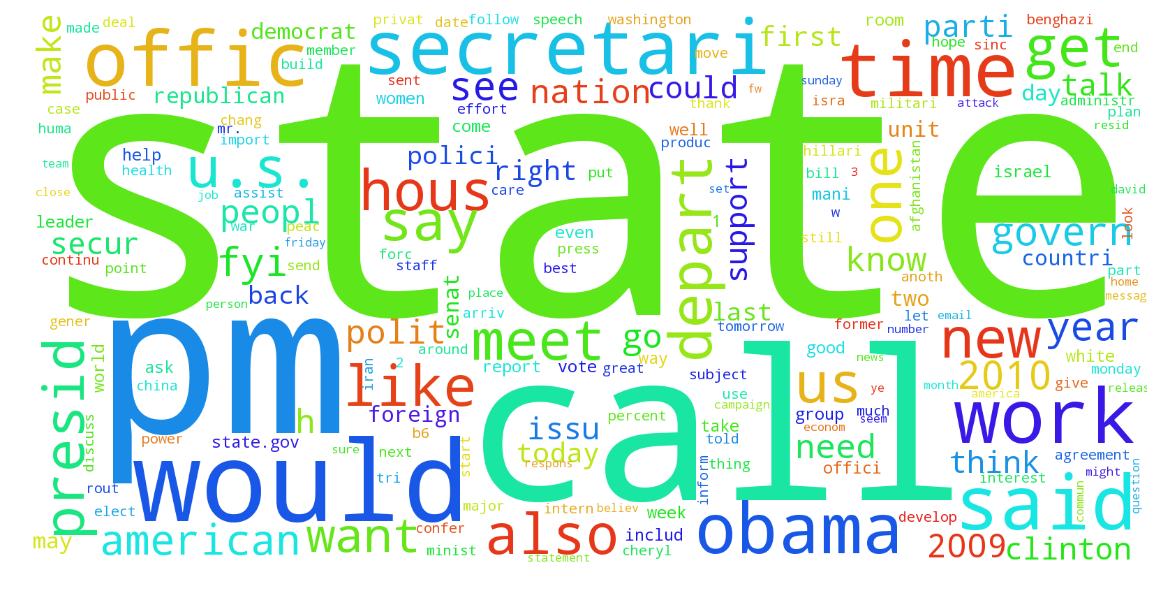

In [86]:
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

There is a significant difference between two generated wordclouds. The main issue of the wordcloud made from raw corpus is that it contains a lot of words which we do not care about (such as articles, preposition, pronouns, etc.) which have a big "weight" and, therefore, have a bigger size on the picture and not many really meaningful words which are small on the picture. The wordcloud made from the tokens after the pre-processing pipeline contains more meaningful words which are related to the topic ("washington", "call", "support", etc.). The main issue of this wordcloud is that meaning of some words can be lost because of stemming (general meaning of some such words can be predicted despite the fact that we can not say exactly what was the original word: "peopl", "produc", whereas meaning of some word is completely lost: "h", "tri", "w").

## Excercise 2

In order to obtain different surface forms (e.g., Switzerland, switzerland, CH) for all existing countries, we used pycountry utility. 
In this cell we found 249 different countries and put that list of countries in variable "countries".

In [12]:
print(len(pycountry.countries))
countries=list(pycountry.countries)

249


In this cell we want to find different surface forms for each of those 249 countries. For each country we take alpha_2 name (name of country expressed in 2 letters, e.g. US), alpha_3 name (name of country expressed in 3 letters, e.g. USA), name of the country (e.g. America), and official name of the country (e.g. United States of America). For names which are not abbrevations (2 and 3 letters names), to possible forms we added also lowercase variant (e.g. america, united states of america). We decided not to add add lowercase variant for abbreviations, cause it may influence results in a wrong way (e.g. for US we don't add us, which is the word which has meaning and apears quite often). Moreover, for each country we made a list of names, and then all those lists we put in one list. Example is to be seen in the output of this cell. 

In [13]:
countries_all_names=[0]*len(countries)
for ind,country in enumerate(countries):
    country_names=[]
    country_names.append(country.alpha_2)
    #countries_all_names.append(country.alpha_2.lower())
    country_names.append(country.alpha_3)
    #countries_all_names.append(country.alpha_3.lower())
    country_names.append(country.name)
    country_names.append(country.name.lower())
    try:
        country_names.append(country.official_name)
        country_names.append(country.official_name.lower())
    except AttributeError:
        pass
    countries_all_names[ind]=country_names
countries_all_names[:3]

[['AW', 'ABW', 'Aruba', 'aruba'],
 ['AF',
  'AFG',
  'Afghanistan',
  'afghanistan',
  'Islamic Republic of Afghanistan',
  'islamic republic of afghanistan'],
 ['AO', 'AGO', 'Angola', 'angola', 'Republic of Angola', 'republic of angola']]

We have email-s which are exchanged among a group of people with who are connected with Hillary Clinton. First goal in this cell is to measure polarity of each email body text (where -1 denotes negative, 0 neutral and 1 positive content). On the beginning we make emails_cleaned DataFrame which is obtained from initial DataFrame by dropping rows which "ExtractedBodyText" field is nan value. We measure sentiment by using vader_analyzer for measuring Sentiment. This analyser returns number from -1 to 1 which denotes polarity of a message. Moreover, for each country name which appear in this email (in any shape) we will take its polarity in account. By iterating through all emails we obtain for each country average score of polarity, by doing summation of polarities of emails where its name appears and then averaging it.    

In [15]:
emails_cleaned = emails.dropna(subset=["ExtractedBodyText"])
emails_cleaned = emails_cleaned["ExtractedBodyText"]
vader_analyzer = SentimentIntensityAnalyzer()
polarity_scores=[0]*len(countries)
num_apper=[0]*len(countries)
for email in emails_cleaned:
    polarity_score = vader_analyzer.polarity_scores(email).get('compound')
    for ind,con in enumerate(countries_all_names):
        for name in con:
            if name in email: 
                polarity_scores[ind]+=polarity_score
                num_apper[ind]+=1
                break
avg_polarity=[0]*len(countries)
for ind,b in enumerate(polarity_scores):
    if num_apper[ind]!=0: avg_polarity[ind] = b / num_apper[ind]

Now, for each country we have number (from -1 to 1) which denotes sentiment in which this country appears in these emails. We want to plot this values in increasing order, and therefore in the next cell we first make list of pairs (country, polarity) and then sort this pairs according to value.

In [17]:
countries_names = [x.name for x in countries]
pairs = [(x,y) for x,y in zip(countries_names,avg_polarity)]
pairs = sorted(pairs, key=itemgetter(1))

In this cell we plot histogram which with one bar representing one country. We notice that values goes from roughly -0.75 to 1. We also colored the graph with spectrume of colours going from red to blue, such that red represents strongly negative sentiment and blue represents strongly positive sentiment. 

<Container object of 249 artists>

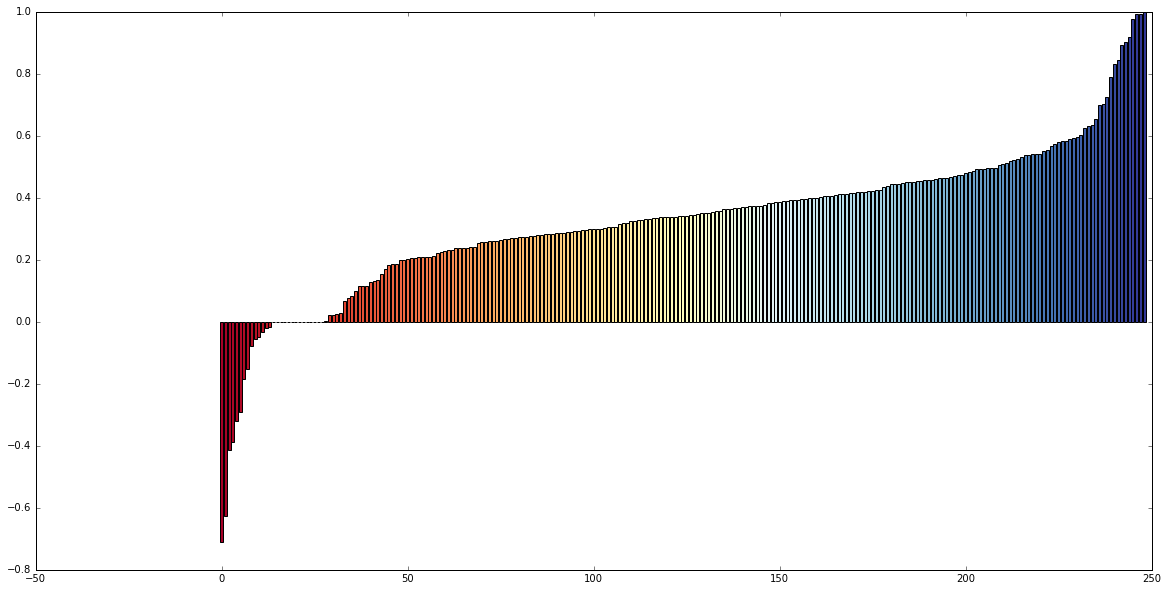

In [18]:
countries_names,polarity = zip(*pairs)
X=range(0,len(countries_names))
plt.figure(figsize = (20, 10))
cm = plt.cm.get_cmap('RdYlBu_r')
x_span = max(X)-min(X)
C = [cm(((x-min(X))/x_span)) for x in range(248,-1,-1)]
plt.bar(X, polarity, color=C, align='center')

As there are many countries and therefore many bars, it is not possible to write countries underneath each bar to denote country it represents. On the other hand, it would be nice to observe values for at least few countries. Therefore, we plotted this graph with approximatelly 10 bars. Code we used is almost the same as in the cell before, with only few small changes of values. 

([<matplotlib.axis.XTick at 0x18fe79ccb00>,
 <a list of 9 Text xticklabel objects>)

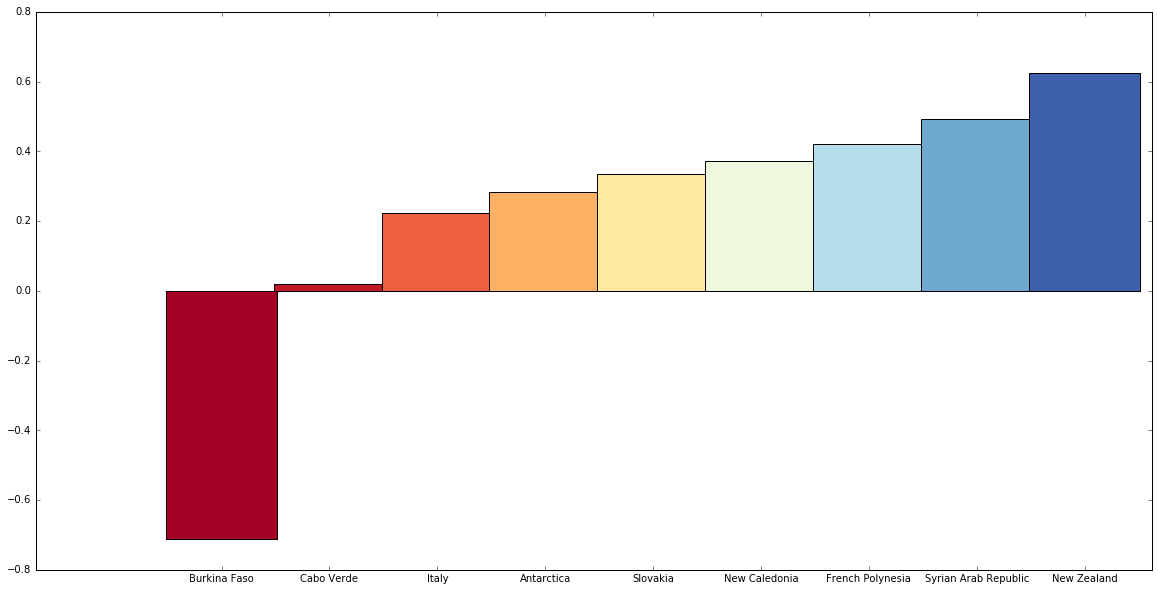

In [19]:
countries_names,polarity = zip(*pairs)
X=range(0,len(countries_names),29)
polarity=polarity[0::29]
plt.figure(figsize = (20, 10))
x_span = max(X)-min(X)
C = [cm(((x-min(X))/x_span)) for x in range(248,-1,-29)]
plt.bar(X, polarity, color=C, align='center', width=30)
plt.xticks(X, countries_names[0::29])

In this part of the task we have the same goals as in the first part, the only difference is that we are going to use other sentiment analyser to calculate polarity of emails. demo_liu_hu_lexicon analyser returns only 3 different values: - 1 for positive, 0 for neutral and -1 for negative sentiment of message. This analyser is written in nltk.sentiment.util module, we just modified it a little bit for our use, but the essence remains the same. 

In [17]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
def demo_liu_hu_lexicon(sentence):
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]
    for word in tokenized_sent:
        if word in opinion_lexicon.positive(): pos_words += 1
        elif word in opinion_lexicon.negative(): neg_words += 1
    if pos_words > neg_words: return (1)
    elif pos_words < neg_words: return (-1)
    elif pos_words == neg_words: return (0)

In this cell we also try to obtain measure of sentiment for each country. Only difference is in how we calculate polarity of one email, in this case we are doing it by calling function demo_liu_hu_lexicon.

In [ ]:
polarity_scores=[0]*len(countries)
num_apper=[0]*len(countries)
for email in emails_cleaned:
    polarity_score = demo_liu_hu_lexicon(email)
    for ind,con in enumerate(countries_all_names):
        for name in con:
            if name in email: 
                polarity_scores[ind]+=polarity_score
                num_apper[ind]+=1
                break
avg_polarity=[0]*len(countries)
for ind,b in enumerate(polarity_scores):
    if num_apper[ind]!=0: avg_polarity[ind] = b / num_apper[ind]

This cell we have already seen before. It sorts countries and their polarity values. 

In [24]:
countries_names = [x.name for x in countries]
pairs = [(x,y) for x,y in zip(countries_names,avg_polarity)]
pairs = sorted(pairs, key=itemgetter(1))

This cell we have also already seen before, it plots histogram for countries and their polarities. We notice difference in this graph in contrast to corresponding graph above. Values of polarities are now in interval [-1, 1]. Shape of this graph is also a little bit different. It has bigger "jumps"- change of value on two ends.

<Container object of 249 artists>

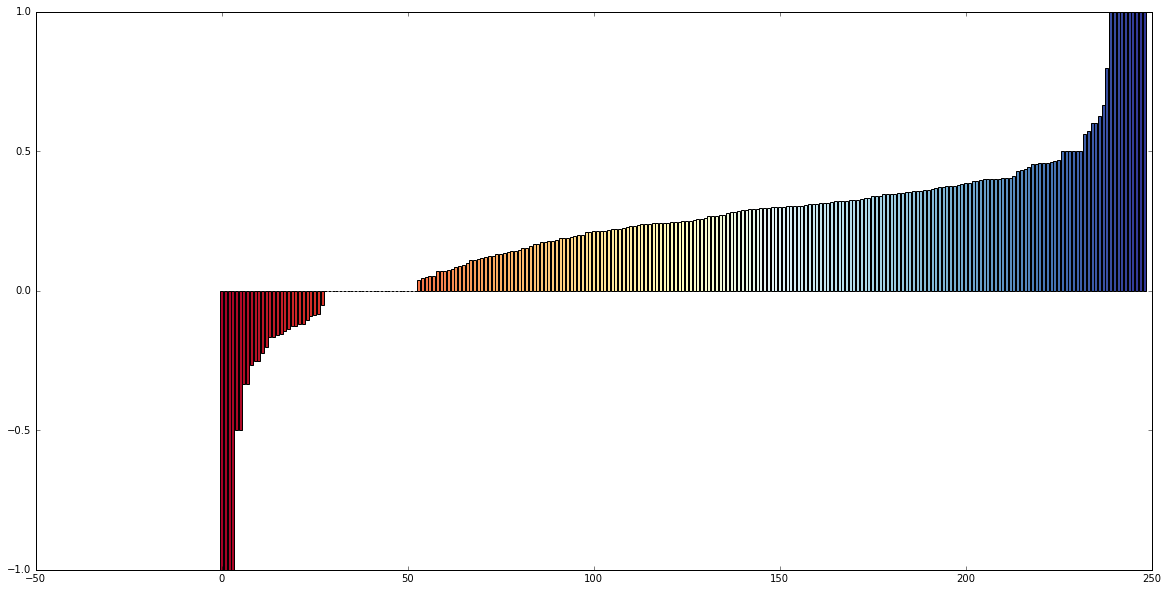

In [25]:
countries_names,polarity = zip(*pairs)
X=range(0,len(countries_names))
plt.figure(figsize = (20, 10))
cm = plt.cm.get_cmap('RdYlBu_r')
x_span = max(X)-min(X)
C = [cm(((x-min(X))/x_span)) for x in range(248,-1,-1)]
plt.bar(X, polarity, color=C, align='center')

For this analyser we also plotted graph with bars for only a few countries just to observe distribution. 

In [ ]:
countries_names,polarity = zip(*pairs)
X=range(0,len(countries_names),29)
polarity=polarity[0::29]
plt.figure(figsize = (20, 10))
x_span = max(X)-min(X)
C = [cm(((x-min(X))/x_span)) for x in range(248,-1,-29)]
plt.bar(X, polarity, color=C, align='center', width=30)
plt.xticks(X, countries_names[0::29])

## Excercise 3

In [72]:
from gensim import corpora
from gensim.models import ldamodel

This excercise is devoted to the topic modelling over corpus. Before strting modelling we do  preparatory work. We create a list of documents. As each document we use concatenation of messages sent by one particular subject.

In [93]:
documents = []
emails_cleaned_twice = emails_raw_cleaned.dropna(subset=["MetadataSubject"])
emails_grouped_by_sender = emails_cleaned_twice.groupby("MetadataSubject")
emails_set = [emails_grouped_by_sender.get_group(x) for x in emails_grouped_by_sender.groups]
for messages_from_one_person in emails_set:
     documents.append(" ".join(messages_from_one_person.ExtractedBodyText))

The pre-processing is done over each document: tokenization, deleting stopwords and deleting word with length less than 4. The last two operation will guarantee that topics obtained during modelling will include significant number of meaningful words.

In [98]:
new_stop = stop + ["would"]
texts = [[word for word in word_tokenize(document.lower()) if word not in new_stop and len(word)>3]
         for document in documents]

As far as we need to find the optimal value of num_topics parameter, the modelling is done inside the loop on each iteration of which we use different value for num_topics.

In [99]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [100]:
for num in range(5, 51, 5):
    print(num, "topics")
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num)
    corpus_lda = lda[corpus]
    for i in range(0, lda.num_topics):
        print("topic #"+str(i+1)+":", lda.print_topic(i, topn=10))

5 topics
topic #1: 0.016*"office" + 0.015*"secretary" + 0.010*"call" + 0.009*"state" + 0.008*"meeting" + 0.007*"department" + 0.007*"room" + 0.006*"time" + 0.005*"arrive" + 0.005*"depart"
topic #2: 0.009*"state" + 0.005*"u.s." + 0.004*"house" + 0.004*"obama" + 0.003*"department" + 0.003*"president" + 0.003*"also" + 0.003*"like" + 0.003*"israel" + 0.003*"benghazi"
topic #3: 0.003*"2009" + 0.003*"said" + 0.003*"time" + 0.003*"u.s." + 0.003*"obama" + 0.003*"last" + 0.003*"president" + 0.002*"iran" + 0.002*"israel" + 0.002*"also"
topic #4: 0.006*"2009" + 0.005*"state.gov" + 0.005*"2010" + 0.004*"president" + 0.003*"cheryl" + 0.003*"obama" + 0.003*"said" + 0.003*"also" + 0.003*"mills" + 0.003*"state"
topic #5: 0.005*"said" + 0.005*"obama" + 0.004*"president" + 0.004*"clinton" + 0.003*"people" + 0.003*"also" + 0.003*"state" + 0.003*"house" + 0.003*"mcchrystal" + 0.003*"policy"
10 topics
topic #1: 0.007*"call" + 0.004*"also" + 0.004*"house" + 0.004*"meeting" + 0.003*"said" + 0.003*"president"

If we look to two extreme points (5 and 50 topics), we will see the main difference: the less the number of topics is, the more general each of them is. For example:

Some of topics among 5 topics:

topic #1: 0.016*"office" + 0.015*"secretary" + 0.010*"call" + 0.009*"state" + 0.008*"meeting" + 0.007*"department" + 0.007*"room" + 0.006*"time" + 0.005*"arrive" + 0.005*"depart" - State Secretary call meeting.

topic #2: 0.009*"state" + 0.005*"u.s." + 0.004*"house" + 0.004*"obama" + 0.003*"department" + 0.003*"president" + 0.003*"also" + 0.003*"like" + 0.003*"israel" + 0.003*"benghazi" U.S. State Department and President Obama did something concerining Israel.

topic #3: 0.003*"2009" + 0.003*"said" + 0.003*"time" + 0.003*"u.s." + 0.003*"obama" + 0.003*"last" + 0.003*"president" + 0.002*"iran" + 0.002*"israel" + 0.002*"also" - President Obama said last time something concerning Iran and Israel.

All this topics are very general.


Some of topics among 50 topics:

topic #38: 0.009*"call" + 0.008*"time" + 0.007*"said" + 0.006*"secretary" + 0.005*"today" + 0.005*"talk" + 0.004*"meeting" + 0.004*"called" + 0.004*"also" + 0.004*"filibuster" Secretary called meeting concerning filibuster.

topic #39: 0.008*"arabs" + 0.006*"israel" + 0.005*"peace" + 0.005*"francisco" + 0.004*"kurdish" + 0.004*"2005." + 0.003*"figures" + 0.003*"israeli" + 0.003*"american" + 0.003*"2009" - Relations between Israel and Arabs in 2009.

topic #40: 0.008*"militias" + 0.007*"2011" + 0.006*"said" + 0.005*"libya" + 0.004*"amendments" + 0.004*"reid" + 0.004*"rebel" + 0.004*"conflict" + 0.004*"sent" + 0.003*"subject" Conflict in Libya in 2011, rebels.

This tendecy is clear.

## Bonus Exercise

In this part of the task we want to plot graph of people who send emails (vertices) and messages exchanged between each pair of vertices (edges). This means that for each to persons wo exchanged email we will plot edge between these two vertices. 
In this cell we read information in DataFrames (Emails.csv and EmailReceivers.csv). We observe that from emails DataFrame we can extract for each email ID of person who sent it. In receivers DataFrame we have lised emails ID-s and ID-s of all people who received that email (email can have more than one recepient). We "groupby" DataFrame by email ID, so that now each group corresponds to one email and contains all receivers of that email. 

In [10]:
import networkx as nx
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', index_col=0)
send_id = emails['SenderPersonId']
receivers_df = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv', index_col=0)
receiv_grouped = receivers_df.groupby('EmailId')

In "edges" list we add pairs of vertices that we need to plot on a graph. So, we iterate through emails (email ID-s). For each email we easily obtain its sender and we also extract list of its receivers, by calling get_group function. For each of these receivers we add pair (sender, receiver) to "edges" list only if both sender and receiver are not nan values. 

In [11]:
edges=[]
for c in receiv_grouped.groups:
    sender = send_id[c] 
    receiv = receiv_grouped.get_group(c).values[:,1].tolist()
    for r in receiv: 
        if str(r)!='nan' and str(sender)!='nan':
            edges.append((sender, r))

By using networkx library we easily create graph object, add "edges" list to it, and draw it.  

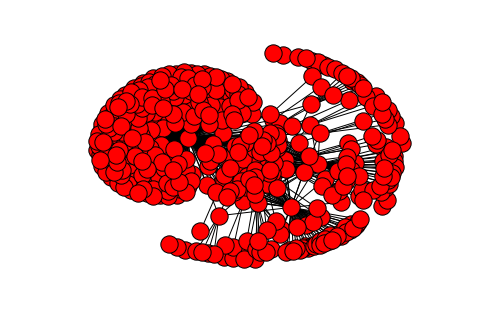

In [12]:
G=nx.Graph()
G.add_edges_from(edges)
nx.draw(G)

In this graph we would now like to observe communites and communication inside those communities. To find communities we use community.best_partition(G) method from the community detection module. We obtaine mapping x->y where each vertex x maps to one of few communities (y). Now we want to extract this information such that for each community we have list of vertices which are belonging to it. We obtained this generaly by doing groupby operation, where we group vertices by number of community they belong. Finally, we will put all those lists in one list. In this cell we also generate no_receive list. We noticed that in receivers DataFrame there are no all emails ID (e.g. row with EmailID = 36 is missing, so we have 35 and then 37). This will make us problem in the future, so we defined list of Email ID-s which are missing from receivers DataFrame. 

In [35]:
import community
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
emails_cleaned = emails.dropna(subset=["ExtractedBodyText"])
partition = community.best_partition(G)
partition_df=pd.DataFrame(partition, index=[0]).transpose()
partition_grouped = partition_df.groupby(0)
community_people=[]
for c in partition_grouped.groups:
    community_people.append(partition_grouped.get_group(c).index.values.tolist())
no_receiv = [i for i in range(1,len(emails)+1) if i not in receivers_df['EmailId'].tolist()]

We observed communities, now we would like to collect all emails which were exchanged inside these communities and print 20 words that appears most in this conversation, in order to get a feeling about topic they are talking about. For each community we iterate through all emails. For every email we first ask if it has receivers (isn't in no_receiv list). If it doesn't have receivers this email doesn't have any meaning to our analyses and we skip it. If receivers are known, for each receiver we ask if she/he is in this community and if sender is in this community, if that is the case, we add body text of this email to collection of email concerning this community. After we iterated through all emails corpus we now have texts of all emails that were exchanged in this community. We do similar analyses of this text as in task one. We tokenize this text, "clean" it from stop words and measure frequency of appearance of each word. Since we want to find 20 most used words we sort words in decreasing order, according to their frequaency of appearing and print them for that community. For each community we repeat same actions. One can notice that for some communities there are no printed words. This can be weird, because if there is a link between vertices in graph in community then those people must have exchanged some emails. We checked, thing is that for some emails bodies are missing. This happens for small communities where only a few emails were exchanged and all of them are with nan email bodies.  

In [39]:
for ind, com in enumerate(community_people):
    email_text=""
    for index,email in emails_cleaned.iterrows():
        if email['Id'] in no_receiv: continue
        receiv = receiv_grouped.get_group(email['Id']).values[:,1].tolist()
        for r in receiv:
            if email['SenderPersonId'] in com and r in com: email_text+=str(email['ExtractedBodyText'])
    email_text_tokens = word_tokenize(email_text.lower())
    stop = stopwords.words('english') + list(string.punctuation) + ["''", '``', '--', '—', '•','.']
    tokens_without_stopwords = [word for word in email_text_tokens if word not in stop]
    fdist = FreqDist(word for word in tokens_without_stopwords)
    fdist_sorted = sorted(fdist, key=fdist.get, reverse=True)
    fdist_sorted
    print ("community: ", ind, " words: \n", fdist_sorted[0:20], "\n")

community:  0  words: 
 [] 

community:  1  words: 
 [] 

community:  2  words: 
 ["'s", 'state', 'would', 'w', 'us', 'department', "n't", 'clinton', 'officials', 'time', 'know', 'see', 'china', 'call', 'intergovernmental', 'get', 'work', 'national', 'obama', '2010'] 

community:  3  words: 
 ['palau', 'u.s.', "'s", 'bahtiyar', 'military', 'brothers', 'uighurs', 'arkin', 'told', 'states', 'united', 'compact', 'brother', 'government', 'said', 'secretary', 'state', 'department', 'china', 'officials'] 

community:  4  words: 
 ["'s", 'u.s.', 'week', 'treaty', 'b6', 'nuclear', 'said', 'also', 'last', 'us', 'new', 'government', 'state', 'start', 'security', 'afghanistan', 'department', 'work', 'house', 'know'] 

community:  5  words: 
 [] 

community:  6  words: 
 ['jamal', 'place', 'deuel', 'kids', 'says', "'s", 'home', "n't", 'dcfs', 'staff', 'state', 'children', "'ve", 'boys', 'good', 'year', 'got', 'group', 'years', 'people'] 

community:  7  words: 
 ['un', 'settlements', 'people', 'ha

Some of words that are among this 20 words for each community are "usual" words such as else, 's, good, thnks, etc. But most of them are very specific, such as names of people (e.g. eric), names of countries (e.g. norway), etc. and other powerful words such as peace, military, convoy, ambassador, etc. which can help us very much realise topic and ton of communication. If we spend more time examining data and if we familiarize ourselves more with US politics, we conclude that it is not very difficult to indentify topic. 

We can spot silmilarities between topics in this part and topics in part 3. For instance, there are topics in part 3, concerning Haity (topic #27: 0.012*"call" + 0.007*"work" + 0.005*"haiti" + 0.005*"also" + 0.005*"need" + 0.004*"know" + 0.004*"time" + 0.004*"tomorrow" + 0.004*"good" + 0.004*"want"), nuclear weapon (topic #22: 0.006*"strategic" + 0.006*"press" + 0.005*"nuclear" + 0.005*"u.s." + 0.004*"talks" + 0.004*"dialogue" + 0.004*"call" + 0.004*"minister" + 0.004*"abbas" + 0.003*"sleep"), China (topic #9: 0.006*"also" + 0.005*"state" + 0.005*"u.s." + 0.005*"states" + 0.004*"china" + 0.004*"people" + 0.003*"president" + 0.003*"american" + 0.003*"mosque" + 0.003*"united"
) etc.